# Cantilever Optimisation

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

try:
    import google.colab

    IN_COLAB = True
    !pip install git+https://github.com/mark-hobbs/pypd.git
    print("Package installed successfully")
    import pypd

    !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
except ImportError:
    IN_COLAB = False
    import pypd

    print("Not running in Colab")

Not running in Colab


In [2]:
if IN_COLAB:
    try:
        gpu_info = !nvidia-smi
        gpu_info = "\n".join(gpu_info)
        print("GPU Information:")
        print(gpu_info)
    except:
        print("GPU information not available")

    try:
        import multiprocessing

        cpu_info = f"Number of CPU cores: {multiprocessing.cpu_count()}"
        print("\nCPU Information:")
        print(cpu_info)
    except:
        print("CPU information not available")
else:
    print("Not running in Colab.")

Not running in Colab.


### Functions required to build the input file

In [3]:
def build_boundary_conditions(particles, dx):
    bc_flag = np.zeros((len(particles), 2), dtype=np.intc)
    bc_unit_vector = np.zeros((len(particles), 2), dtype=np.intc)

    tol = 1e-6

    for i, particle in enumerate(particles):
        if particle[0] < (0.1 + tol):
            bc_flag[i, :] = 1
            bc_unit_vector[i, :] = 0
        if particle[0] > (9.9 - dx - tol):
            bc_flag[i, 1] = 1
            bc_unit_vector[i, 1] = -1

    return bc_flag, bc_unit_vector

In [4]:
def build_particle_coordinates(dx, length, height):
    """
    Build particle coordinates for a rectangular grid, handling negative lengths and heights.
    
    Parameters
    ----------
    dx : float
        Spacing between particles.
    length : float
        Length of the region (can be negative).
    height : float
        Height of the region (can be negative).

    Returns
    -------
    particle_coordinates : np.ndarray
        Particle coordinates in the grid.
    """
    n_div_x = int(np.abs(length) // dx)
    n_div_y = int(np.abs(height) // dx)
    
    x_coords, y_coords = np.meshgrid(np.arange(n_div_x) * np.sign(length) * dx, 
                                     np.arange(n_div_y) * np.sign(height) * dx)
    
    return np.column_stack([x_coords.ravel(), y_coords.ravel()])

In [5]:
import math

def bernstein_poly(i, n, t):
    """
    Compute the Bernstein polynomial B_{i,n}(t).
    
    Parameters:
    i (int): Index of the polynomial.
    n (int): Degree of the polynomial.
    t (float or np.array): Normalized position along the beam (0 <= t <= 1).
    
    Returns:
    float or np.array: Value of the Bernstein polynomial.
    """
    return math.comb(n, i) * (t**i) * ((1 - t)**(n - i))

In [6]:
def beam_depth_bernstein(x, control_points, L):
    """
    Compute the depth of the beam using Bernstein polynomials.
    
    Parameters:
    x (np.array): Position along the beam (0 <= x <= L).
    control_points (list or np.array): Control points defining the beam depth.
    L (float): Length of the beam.
    
    Returns:
    np.array: Depth of the beam at each position x.
    """
    n = len(control_points) - 1  # Degree of Bernstein polynomial
    t = x / L  # Normalise x to the range [0, 1]
    
    h_x = np.zeros_like(x)
    
    for i, c_i in enumerate(control_points):
        h_x += c_i * bernstein_poly(i, n, t)
    
    return h_x

### Build the particles and boundary conditions

In [7]:
L = 10.0 
l = np.linspace(0, L, 100)
control_points = [-1.0, -0.5, -0.2]
h_x = beam_depth_bernstein(l, control_points, L)

dx = 0.025
x = build_particle_coordinates(dx, 10, -2)

polygon_points = np.vstack((np.column_stack([l, h_x]), np.column_stack([l[::-1], np.zeros_like(l[::-1])])))
from matplotlib.path import Path
beam_shape_path = Path(polygon_points)

mask = beam_shape_path.contains_points(x)
x = x[mask]

flag, unit_vector = build_boundary_conditions(x, dx)

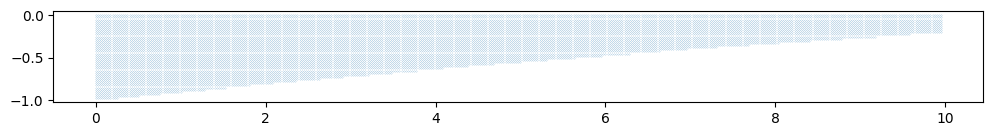

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(x[:, 0], x[:, 1], s=0.01)
ax.set_aspect("equal")

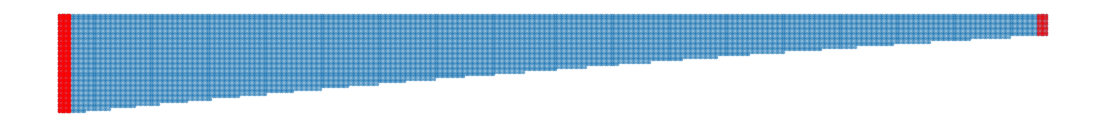

In [9]:
fig, ax = plt.subplots(figsize=(14, 7.5))
ax.scatter(x[:, 0], x[:, 1], marker="o", s=2.5, alpha=0.5)
ax.scatter(
    x[np.where(flag)[0], 0],
    x[np.where(flag)[0], 1],
    marker="o",
    s=2.5,
    c="red",
    alpha=0.5,
)
ax.axis("off")
ax.set_aspect("equal")

### Build the model

If we are only interested in studying the deformed shape of the plate, we can switch off damage in the `ConstitutiveModel` class by setting `damage_on` to `False`.

In [10]:
material = pypd.Material(name="quasi-brittle", E=33e9, Gf=130, density=2400, ft=2.5)
integrator = pypd.EulerCromer()
bc = pypd.BoundaryConditions(flag, unit_vector, magnitude=1e-2)
particles = pypd.ParticleSet(x, dx, bc, material)
linear = pypd.Linear(material, particles, t=dx, damage_on=False)
bonds = pypd.BondSet(particles, linear)
simulation = pypd.Simulation(dt=None, n_time_steps=20000, damping=0)

model = pypd.Model(
    particles,
    bonds,
    simulation,
    integrator,
    linear,
)

In [11]:
model.run_simulation()

Simulation Progress: 100%|███████████████████████████████████████████████| 20000/20000 [00:37<00:00, 536.99steps/s]


### Visualise the deformation of the beam

In [12]:
dsf = 10  # displacement scale factor

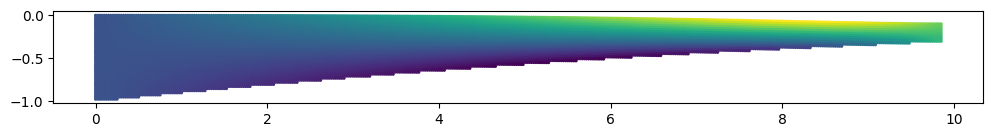

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(
    model.particles.x[:, 0] + (model.particles.u[:, 1] * dsf),
    model.particles.x[:, 1] + (model.particles.u[:, 1] * dsf),
    c=model.particles.u[:, 0],
    s=2
)
ax.set_aspect("equal")

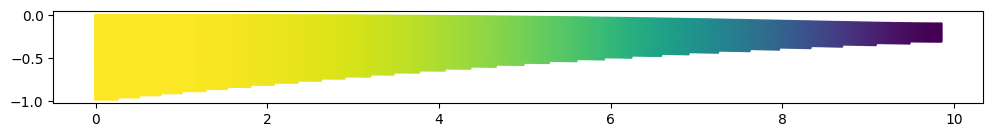

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(
    model.particles.x[:, 0] + (model.particles.u[:, 1] * dsf),
    model.particles.x[:, 1] + (model.particles.u[:, 1] * dsf),
    c=model.particles.u[:, 1],
    s=2
)
ax.set_aspect("equal")